# Clonamos el repositorio para obtener los dataSet

In [1]:
!git clone https://github.com/joanby/tensorflow.git

Cloning into 'tensorflow'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 60311 (delta 32), reused 37 (delta 23), pack-reused 60260
Receiving objects: 100% (60311/60311), 442.46 MiB | 32.62 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Checking out files: 100% (60225/60225), done.


# Damos acceso a nuestro Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Test it

In [ ]:
!ls '/content/drive/My Drive' 

# Google colab tools

In [3]:
from google.colab import files # Para manejar los archivos y, por ejemplo, exportar a su navegador
import glob # Para manejar los archivos y, por ejemplo, exportar a su navegador
from google.colab import drive # Montar tu Google drive

##Especificando la versión de TensorFlow

Ejecutando "importar tensorflow" importará la versión por defecto (actualmente 2.x). Puedes usar la 1.x ejecutando una celda con la "versión mágica de tensorflow" **antes de ejecutar "importar tensorflow".

### Si no funciona hacer el pip install


In [4]:
#!pip install tensorflow==1.14
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Importar Tensorflow

In [5]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt

1.15.2


In [6]:
session = tf.Session()

# Doc2Vec

In [9]:
import sys
sys.path.append('/content/tensorflow/scripts/tema08/')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import string
import nlp_helpers
import pickle
import os
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
session = tf.Session()

In [11]:
texts, target = nlp_helpers.load_movies_data()

In [12]:
batch_size = 500
vocabulary_size = 7500
generations = 20000
model_learning_rate = 0.001
embedding_size = 200
doc_embedding_size = 100
concatenated_size = embedding_size + doc_embedding_size
num_sampled = int(batch_size/2)
window_size = 3

save_embedding_every = 1000
print_valid_every = 2000
print_loss_every = 500

stops = stopwords.words('english')
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman', 'movie']

In [13]:
texts = nlp_helpers.normalize_text(texts, stops)
target = [target[ix] for ix, x in enumerate(texts) if len(x.split())>window_size]
texts = [x for x in texts if len(x.split())>window_size]
assert(len(target)==len(texts))

In [14]:
word_dictionary = nlp_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = nlp_helpers.text_to_numbers(texts, word_dictionary)
valid_examples = [word_dictionary[x] for x in valid_words]
valid_examples

[28, 980, 791, 354, 131, 565, 2]

In [15]:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0,1.0))
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                             stddev=1.0/np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [16]:
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size+1])
y_target = tf.placeholder(tf.int32, shape = [None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [17]:
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])
doc_idx = tf.slice(x_inputs, [0, window_size], [batch_size,1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings, doc_idx)
final_embed = tf.concat([embed, tf.squeeze(doc_embed)], axis=1)

In [18]:
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                                    labels = y_target, inputs = final_embed,
                                    num_sampled=num_sampled, num_classes = vocabulary_size))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
optim = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optim.minimize(loss)

In [20]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings),1, keepdims=True))
normalized_embeddings = embeddings/norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [21]:
saver = tf.train.Saver({"embeddings":embeddings, "doc_embeddings":doc_embeddings})
init = tf.global_variables_initializer()
session.run(init)

In [23]:
loss_vect = []
loss_x_vect = []
for i in range(generations):
    batch_inputs, batch_labels = nlp_helpers.generate_batch_data(text_data, batch_size, window_size, 'doc2vec')
    feed_dict = {x_inputs: batch_inputs, y_target: batch_labels}
    session.run(train_step, feed_dict=feed_dict)
    
    if(i+1) % print_loss_every == 0:
        loss_val = session.run(loss, feed_dict=feed_dict)
        loss_vect.append(loss_val)
        loss_x_vect.append(i+1)
        print("Pérdidas en el paso {}: {}".format(i+1, loss_val))
        
    if(i+1) % print_valid_every == 0:
        sim = session.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5
            nearest = (-sim[j,:]).argsort()[1:top_k+1]
            log_str = "Palabras más cercanas a {}: ".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{}\n -{}'.format(log_str, close_word)
            print(log_str)
    if (i+1) % save_embedding_every == 0:
        with open(os.path.join("../../datasets", 'doc2vec_movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        model_checkpoint_path = os.path.join("../datasets", 'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(session, model_checkpoint_path)
        print("Modelo guardado en: {}".format(save_path))

Pérdidas en el paso 500: 3.2302613258361816
Pérdidas en el paso 1000: 3.924816131591797
Modelo guardado en: ../datasets/doc2vec_movie_embeddings.ckpt
Pérdidas en el paso 1500: 4.3979105949401855
Pérdidas en el paso 2000: 2.879021167755127
Palabras más cercanas a love: 
 -pg
 -particular
 -economic
 -refuse
 -intricate
Palabras más cercanas a hate: 
 -dreamlike
 -find
 -inoffensive
 -assembles
 -bare
Palabras más cercanas a happy: 
 -subculture
 -malcolm
 -family
 -folk
 -blend
Palabras más cercanas a sad: 
 -anarchists
 -brain
 -vincents
 -collectively
 -struggle
Palabras más cercanas a man: 
 -carries
 -editing
 -intellectual
 -restrained
 -festival
Palabras más cercanas a woman: 
 -slow
 -chills
 -bucks
 -outtakes
 -tugofwar
Palabras más cercanas a movie: 
 -majority
 -rooted
 -angry
 -efficient
 -davies
Modelo guardado en: ../datasets/doc2vec_movie_embeddings.ckpt
Pérdidas en el paso 2500: 4.6383185386657715
Pérdidas en el paso 3000: 2.74904203414917
Modelo guardado en: ../datasets/

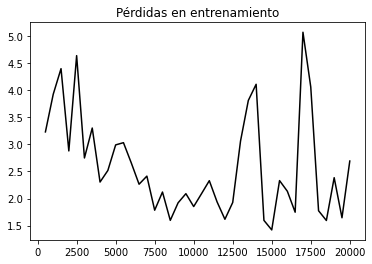

In [24]:
plt.plot(loss_x_vect, loss_vect, 'k-', label = "Función de pérdidas")
plt.title("Pérdidas en entrenamiento")
plt.show()

## Análisis de sentimiento con doc2vec

In [25]:
max_words = 20
logistic_batch_size = 500 

In [26]:
train_idx = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace = False))
test_idx = np.sort(np.array(list(set(range(len(target)))-set(train_idx))))

In [27]:
texts_train = [x for ix, x in enumerate(texts) if ix in train_idx]
texts_test = [x for ix, x in enumerate(texts) if ix in test_idx]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_idx])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_idx])

In [28]:
text_data_train = np.array(nlp_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(nlp_helpers.text_to_numbers(texts_test, word_dictionary))

text_data_train = np.array([x[0:max_words] for x in [y + [0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y + [0]*max_words for y in text_data_test]])

In [29]:
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words+1])
log_y_target = tf.placeholder(tf.int32, shape=[None,1])

In [30]:
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])
log_doc_idx = tf.slice(log_x_inputs, [0, max_words], [logistic_batch_size, 1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings, log_doc_idx)
log_final_embed = tf.concat([log_embed, tf.squeeze(log_doc_embed)], axis = 1)

In [31]:
A = tf.Variable(tf.random_normal(shape=[concatenated_size, 1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
model_output = tf.add(tf.matmul(log_final_embed, A), b)
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, 
                                                                       labels=tf.cast(log_y_target, tf.float32)))

In [32]:
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [33]:
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A,b])

In [34]:
init = tf.global_variables_initializer()
session.run(init)

In [35]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []

for i in range(10000):
    rand_idx = np.random.choice(text_data_train.shape[0], size = logistic_batch_size)
    rand_x = text_data_train[rand_idx]
    rand_x_doc_idx = train_idx[rand_idx]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_idx])))
    rand_y = np.transpose([target_train[rand_idx]])
    
    feed_dict={log_x_inputs: rand_x, log_y_target: rand_y}
    session.run(logistic_train_step, feed_dict=feed_dict)
    
    if(i+1)%100==0:
        
        rand_idx_test = np.random.choice(text_data_test.shape[0], size = logistic_batch_size)
        rand_x_test = text_data_test[rand_idx_test]
        rand_x_doc_idx_test = test_idx[rand_idx_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_idx_test])))
        rand_y_test = np.transpose([target_test[rand_idx_test]])

        feed_dict_test={log_x_inputs: rand_x_test, log_y_target: rand_y_test}
    
        
        i_data.append(i+1)
        
        train_loss_temp = session.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = session.run(logistic_loss, feed_dict=feed_dict_test)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = session.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
        
        test_acc_temp = session.run(accuracy, feed_dict=feed_dict_test)
        test_acc.append(test_acc_temp)
        
    if(i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Paso #{}, Train Loss {}, Test Loss {}. Train Acc {}, Test Acc{}".format(*acc_and_loss))

Paso #500, Train Loss 9.916999816894531, Test Loss 10.440999984741211. Train Acc 0.5320000052452087, Test Acc0.48399999737739563
Paso #1000, Train Loss 7.810999870300293, Test Loss 7.452000141143799. Train Acc 0.46799999475479126, Test Acc0.5220000147819519
Paso #1500, Train Loss 10.583000183105469, Test Loss 10.109000205993652. Train Acc 0.5040000081062317, Test Acc0.5080000162124634
Paso #2000, Train Loss 10.065999984741211, Test Loss 10.208999633789062. Train Acc 0.5180000066757202, Test Acc0.49399998784065247
Paso #2500, Train Loss 10.164999961853027, Test Loss 11.449999809265137. Train Acc 0.5400000214576721, Test Acc0.5139999985694885
Paso #3000, Train Loss 11.38599967956543, Test Loss 12.005999565124512. Train Acc 0.5419999957084656, Test Acc0.5419999957084656
Paso #3500, Train Loss 8.847000122070312, Test Loss 8.494999885559082. Train Acc 0.4860000014305115, Test Acc0.5199999809265137
Paso #4000, Train Loss 9.538000106811523, Test Loss 9.26099967956543. Train Acc 0.526000022888

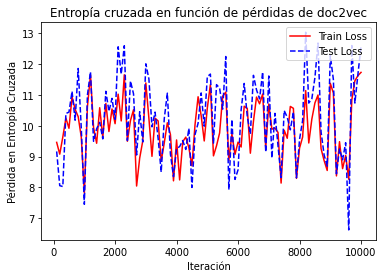

In [36]:
plt.plot(i_data, train_loss, 'r-', label="Train Loss")
plt.plot(i_data, test_loss, 'b--', label="Test Loss")
plt.title("Entropía cruzada en función de pérdidas de doc2vec")
plt.xlabel("Iteración")
plt.ylabel("Pérdida en Entropía Cruzada")
plt.legend(loc = "upper right")
plt.show()

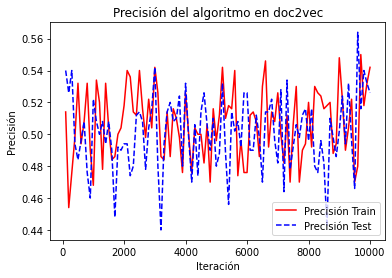

In [37]:
∫plt.plot(i_data, train_acc, 'r-', label="Precisión Train")
plt.plot(i_data, test_acc, 'b--', label="Precisión Test")
plt.title("Precisión del algoritmo en doc2vec")
plt.xlabel("Iteración")
plt.ylabel("Precisión")
plt.legend(loc = "lower right")
plt.show()